# Part 1  Learning and crop the skin

In [ ]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from numpy import ndarray
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors
import os
from PIL import Image

import the image

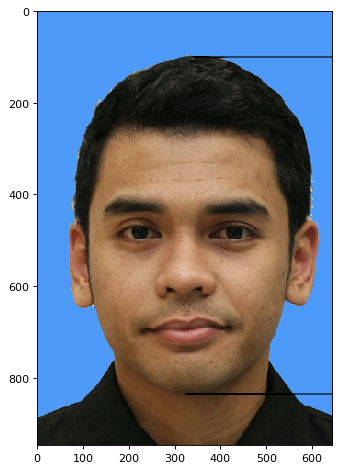

In [ ]:
original_face = imread('/content/drive/MyDrive/images/photo 2.png')
plt.figure(num=None, figsize=(8, 6), dpi=80)
imshow(original_face);

split the image

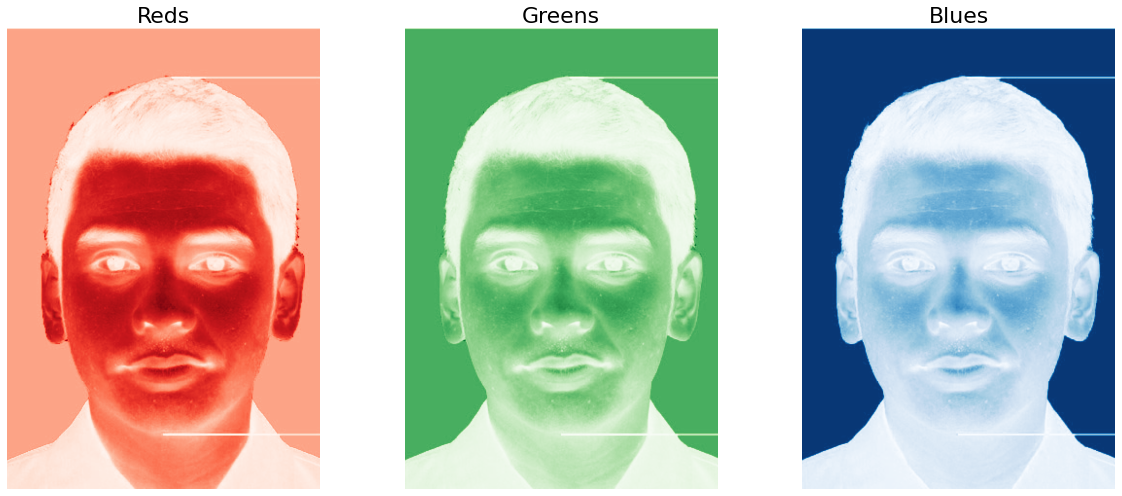

In [ ]:
def rgb_splitter(image):
    rgb_list = ['Reds','Greens','Blues']
    fig, ax = plt.subplots(1, 3, figsize=(17,7), sharey = True)
    for i in range(3):
        ax[i].imshow(image[:,:,i], cmap = rgb_list[i])
        ax[i].set_title(rgb_list[i], fontsize = 22)
        ax[i].axis('off')
    fig.tight_layout()
rgb_splitter(original_face)

Calculate the rg chromaticity values for each pixel and Build RG Chromaticity Graphs

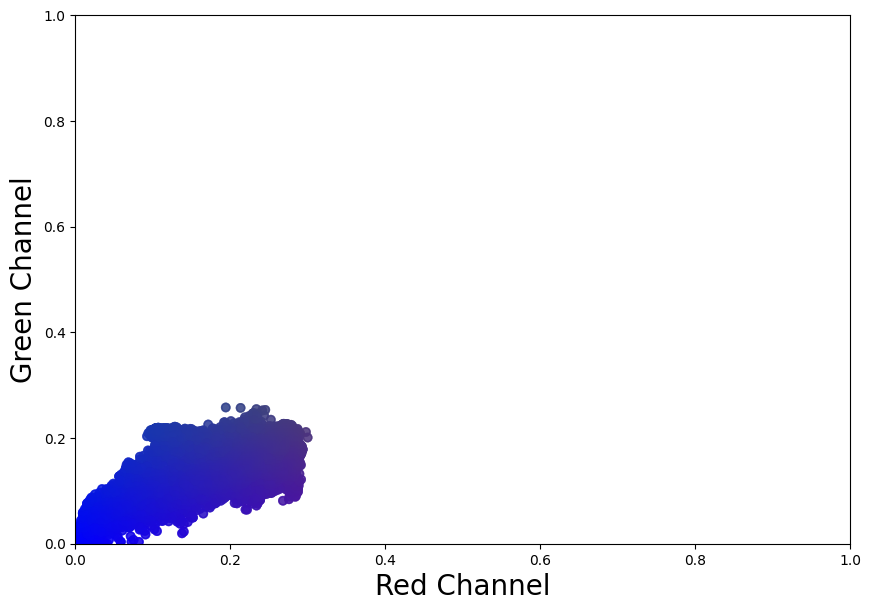

In [ ]:
np.seterr(invalid='ignore')
original_face_r = original_face[:,:,0] /original_face.sum(axis=2)
original_face_g = original_face[:,:,1] /original_face.sum(axis=2)

def RG_Chroma_plotter(red,green):
    p_color = [(r, g, 1-r-g) for r,g in 
               zip(red.flatten(),green.flatten())]
    norm = colors.Normalize(vmin=0,vmax=1.)
    norm.autoscale(p_color)
    p_color = norm(p_color).tolist()
    fig = plt.figure(figsize=(10, 7), dpi=100)
    ax = fig.add_subplot(111)
    ax.scatter(red.flatten(), 
                green.flatten(), 
                c = p_color, alpha = 0.40)
    ax.set_xlabel('Red Channel', fontsize = 20)
    ax.set_ylabel('Green Channel', fontsize = 20)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    plt.show()
RG_Chroma_plotter(original_face_r,original_face_g)

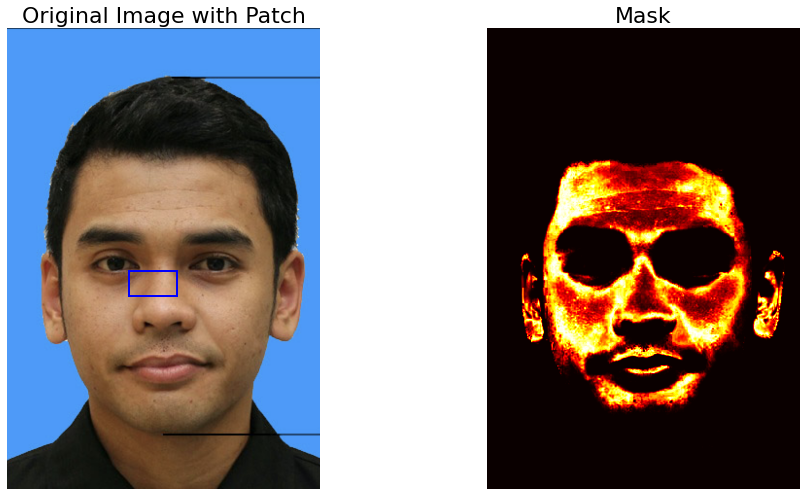

In [ ]:
def gaussian(p,mean,std):
    return np.exp(-(p-mean)**2/(2*std**2))*(1/(std*((2*np.pi)**0.5)))
def rg_chroma_patch(image, patch_coor, mean = 1, std = 1):
    patch = image[patch_coor[0]:patch_coor[1],
                  patch_coor[2]:patch_coor[3]]
    
    image_r = image[:,:,0] /image.sum(axis=2)
    image_g = image[:,:,1] /image.sum(axis=2)
    
    patch_r = patch[:,:,0] / patch.sum(axis=2)
    patch_g = patch[:,:,1] / patch.sum(axis=2)
    
    std_patch_r = np.std(patch_r.flatten())
    mean_patch_r = np.mean(patch_r.flatten())
    std_patch_g = np.std(patch_g.flatten())
    mean_patch_g = np.mean(patch_g.flatten())
    masked_image_r = gaussian(image_r, mean_patch_r, std_patch_r)
    masked_image_g = gaussian(image_g, mean_patch_g, std_patch_g)
    final_mask = masked_image_r * masked_image_g
    fig, ax = plt.subplots(1,2, figsize=(15,7))
    ax[0].imshow(image)
    ax[0].add_patch(Rectangle((patch_coor[2], patch_coor[0]), 
                               patch_coor[1] - patch_coor[0], 
                               patch_coor[3] - patch_coor[2], 
                               linewidth=2,
                               edgecolor='b', facecolor='none'));
    ax[0].set_title('Original Image with Patch', fontsize = 22)
    ax[0].set_axis_off()
    
    #clean the mask using area_opening
    ax[1].imshow(final_mask, cmap = 'hot');
    ax[1].set_title('Mask', fontsize = 22)
    ax[1].set_axis_off()
    fig.tight_layout()
    
    return final_mask

final_mask = rg_chroma_patch(original_face, [500,600,250,300])

show skin

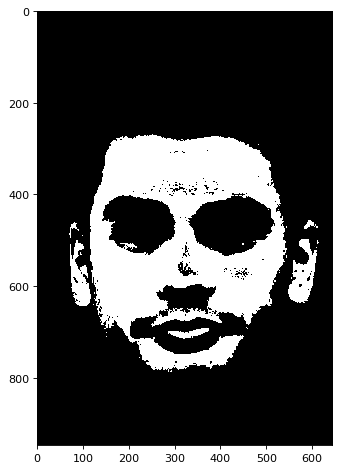

In [ ]:
original_face_mask = final_mask > final_mask.mean()
plt.figure(num=None, figsize=(8, 6), dpi=80)
imshow(original_face_mask)

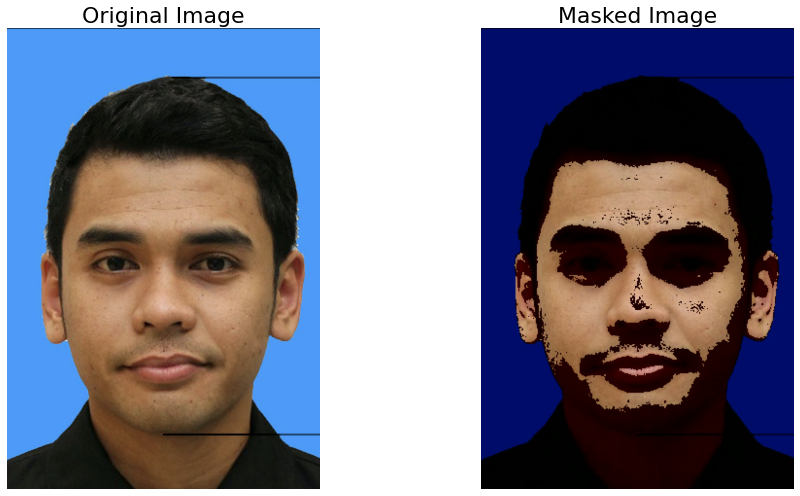

In [ ]:
def apply_mask(image,mask):
    yuv_image = cv.cvtColor(image,cv.COLOR_RGB2YUV)
    yuv_image[:,:,0] = yuv_image[:,:,0] * mask

    masked_image = cv.cvtColor(yuv_image, cv.COLOR_YUV2RGB)
    
    fig, ax = plt.subplots(1,2, figsize=(15,7))
    ax[0].imshow(image)
    ax[0].set_title('Original Image', fontsize = 22)
    ax[0].set_axis_off()
    
    ax[1].imshow(masked_image);
    ax[1].set_title('Masked Image', fontsize = 22)
    ax[1].set_axis_off()
    fig.tight_layout()

apply_mask(original_face,original_face_mask)

# Part 2 Calculate a colour (chromaticity) distribution for these pixels and model the background distribution

(100, 100, 4)
(100, 100, 4)
(100, 100, 4)
(890, 970, 4)
(948, 644, 4)
(458, 464, 4)


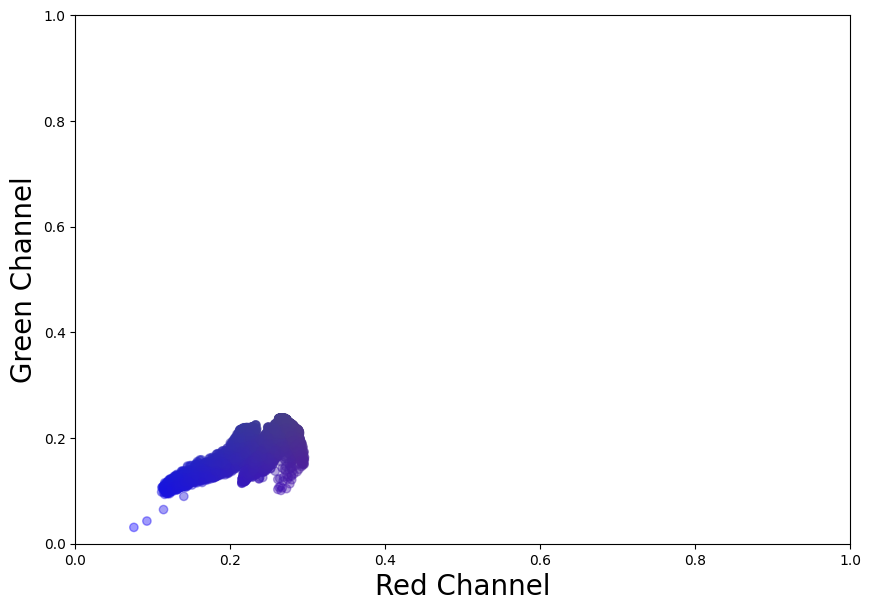

In [ ]:
# use different faces as the patch to model the distribution
# why I only crop one patch in a same picture? Because I use the photo id, there are a little difference in the same face
original_face_1 = imread('/content/drive/MyDrive/images/photo 1.png')
original_face_2 = imread('/content/drive/MyDrive/images/photo 2.png')
original_face_3 = imread('/content/drive/MyDrive/images/photo 3.png')
original_face_1_patch = cv.resize(original_face_1[230:400,400:600],(100,100))
original_face_2_patch = cv.resize(original_face_2[500:600,220:430],(100,100))
original_face_3_patch = cv.resize(original_face_3[210:290,150:300],(100,100))

# print the shape, because if we hope to use cv.vconcat, we must use the same size picture
print(original_face_1_patch.shape)
print(original_face_2_patch.shape)
print(original_face_3_patch.shape)
print(original_face_1.shape)
print(original_face_2.shape)
print(original_face_3.shape)

#combine different patches
patch=cv.vconcat([original_face_1_patch,original_face_2_patch,original_face_3_patch])

#Calculate chromaticity distribution for these pixels. 
patch_r = patch[:,:,0] /patch.sum(axis=2)
patch_g = patch[:,:,1] /patch.sum(axis=2)
RG_Chroma_plotter(patch_r,patch_g)
std_patch_r = np.std(patch_r.flatten())
mean_patch_r = np.mean(patch_r.flatten())
std_patch_g = np.std(patch_g.flatten())
mean_patch_g = np.mean(patch_g.flatten())

Use the non-skin pixels to model the background distribution

(100, 100, 4)
(100, 100, 4)
(100, 100, 4)


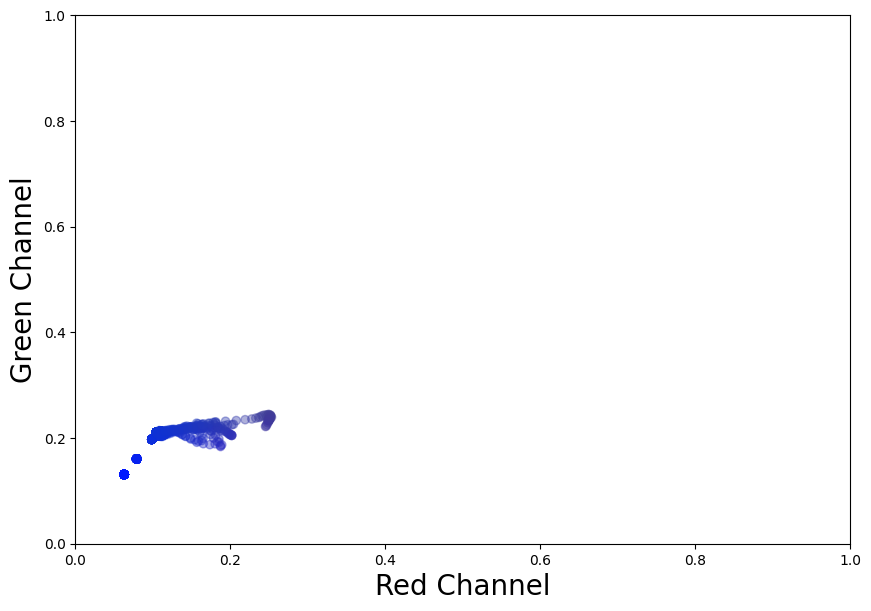

In [ ]:
original_noneface_1_patch = cv.resize(original_face_1[600:800,0:200],(100,100))
original_noneface_2_patch = cv.resize(original_face_2[0:50,100:600],(100,100))
original_noneface_3_patch = cv.resize(original_face_3[0:500,0:50],(100,100))

# print the shape, because if we hope to use cv.vconcat, we must use the same size picture
print(original_noneface_1_patch.shape)
print(original_noneface_2_patch.shape)
print(original_noneface_3_patch.shape)

#combine different patches
patch2=cv.vconcat([original_noneface_1_patch,original_noneface_2_patch,original_noneface_3_patch])

#Calculate chromaticity distribution for these pixels. 
patch2_r = patch2[:,:,0] /patch2.sum(axis=2)
patch2_g = patch2[:,:,1] /patch2.sum(axis=2)
RG_Chroma_plotter(patch2_r,patch2_g)
std_patch2_r = np.std(patch2_r.flatten())
mean_patch2_r = np.mean(patch2_r.flatten())
std_patch2_g = np.std(patch2_g.flatten())
mean_patch2_g = np.mean(patch2_g.flatten())

# Part 3 Use distribution to find the skin regions in new images

<Figure size 640x480 with 0 Axes>

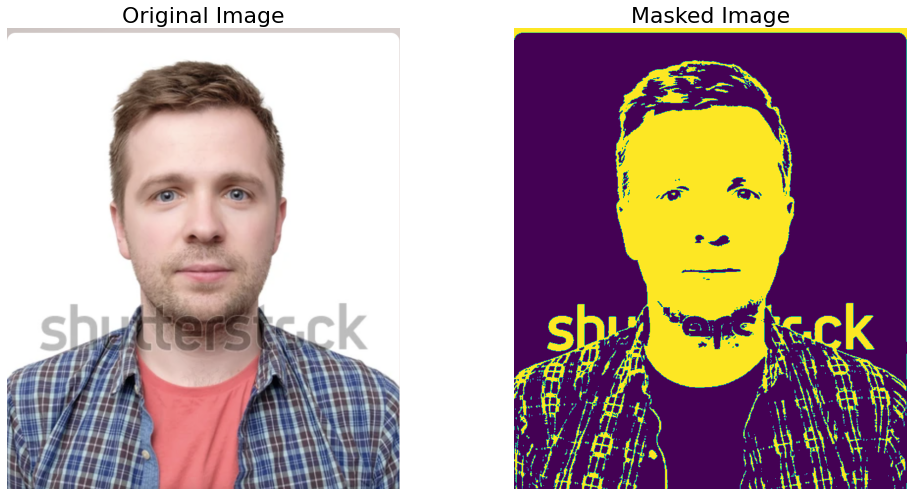

<Figure size 640x480 with 0 Axes>

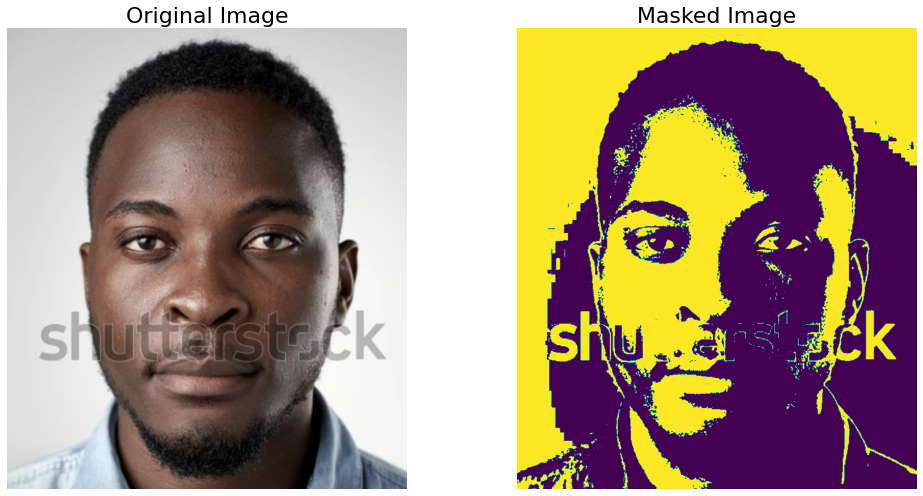

<Figure size 640x480 with 0 Axes>

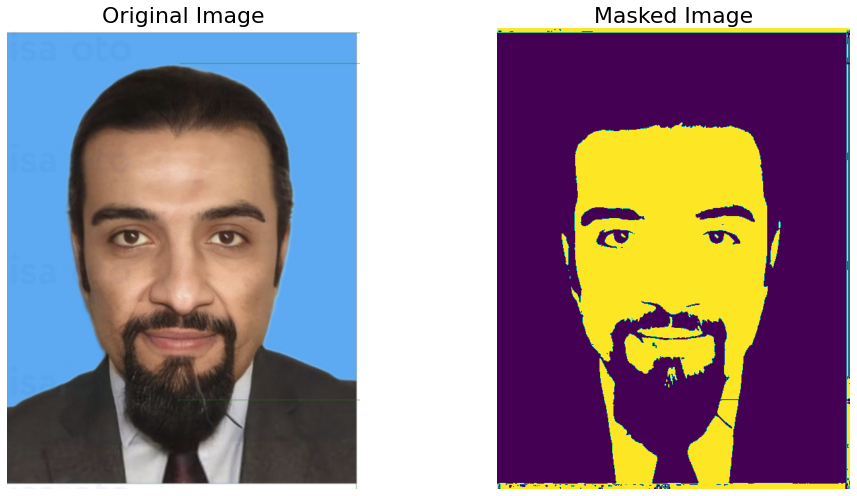

In [ ]:
def find_skin(image):
  mean = 1
  std = 1
  
  image=imread(image)
  
  image_r = image[:,:,0] /image.sum(axis=2)
  image_g = image[:,:,1] /image.sum(axis=2)

  masked_image_r = gaussian(image_r, mean_patch_r, std_patch_r)
  masked_image_g = gaussian(image_g, mean_patch_g, std_patch_g)
  final_mask = masked_image_r * masked_image_g


  original_face_mask = final_mask > final_mask.mean()
  plt.figure(num=None, figsize=(8, 6), dpi=80)

  # imshow(original_face_mask)

  fig, ax = plt.subplots(1,2, figsize=(15,7))
  ax[0].imshow(image)
  ax[0].set_title('Original Image', fontsize = 22)
  ax[0].set_axis_off()

  ax[1].imshow(original_face_mask);
  ax[1].set_title('Masked Image', fontsize = 22)
  ax[1].set_axis_off()
  fig.tight_layout()


  # yuv_image = cv.cvtColor(image,cv.COLOR_RGB2YUV)
  # yuv_image[:,:,0] = yuv_image[:,:,0] * original_face_mask

  # masked_image = cv.cvtColor(yuv_image, cv.COLOR_YUV2RGB)

  # fig, ax = plt.subplots(1,2, figsize=(15,7))
  # ax[0].imshow(image)
  # ax[0].set_title('Original Image', fontsize = 22)
  # ax[0].set_axis_off()

  # ax[1].imshow(masked_image);
  # ax[1].set_title('Masked Image', fontsize = 22)
  # ax[1].set_axis_off()
  # fig.tight_layout()

  return final_mask

final_mask = find_skin('/content/drive/MyDrive/images/photo 4.png')
final_mask = find_skin('/content/drive/MyDrive/images/photo 5.png')
final_mask = find_skin('/content/drive/MyDrive/images/photo 6.png')

Mark the skin as the yellow, as you can see, the photo 6 had the best result and the photo 5 was not good.

# Part 4 How sensitive is your algorithm to changes in brightness

In [ ]:
def brightness(image,num):
  img = imread(image)
  img_t = cv.cvtColor(img,cv.COLOR_BGR2HSV)
  h,s,v = cv.split(img_t)
  num = 1 + num
  #print(img_t)
  #Make the new images 15% brighter
  v1 = np.clip(cv.add(num*v,0),0,255)

  #trans mandatorily the arrry v1 type for mergeing the image
  v1 = v1.astype(np.uint8)
  #print(v1)

  img1 = np.uint8(cv.merge((h,s,v1)))
  img1 = cv.cvtColor(img1,cv.COLOR_HSV2BGR)
  
  fig, ax = plt.subplots(1,2, figsize=(15,7))
  ax[0].imshow(img)
  ax[0].set_title('Original Image', fontsize = 22)
  ax[0].set_axis_off()

  ax[1].imshow(img1);
  ax[1].set_title('Change Brightness Image', fontsize = 22)
  ax[1].set_axis_off()
  fig.tight_layout()

  #I do real spend too much time to deal why the method find_skin could not deal the picture after changing brightness
  #Finally, I found that when I use the hsv to deal it, it lost the transparency, so I need to fix it.
  plt.savefig("tem.png")
  img = Image.open("/content/tem.png")
  img = img.convert('RGBA')
  img_blender = Image.new('RGBA', img.size, (0,0,0,0))
  img = Image.blend(img_blender, img, 1)
  img.save("tem1.png")
  img = imread('/content/tem1.png')
  
  return img

In [ ]:
img_brighter = brightness('/content/drive/MyDrive/images/photo 1.png',0.35)
#print(img_brighter)
final_mask = find_skin('/content/tem1.png')


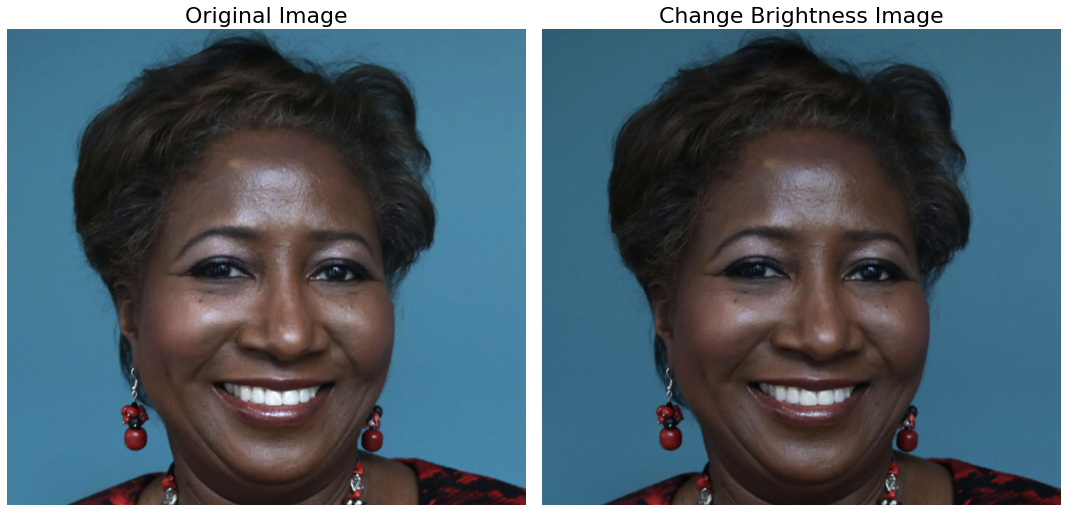

In [ ]:
img_darker = brightness('/content/drive/MyDrive/images/photo 1.png',-0.15)
#print(img_brighter)
final_mask = find_skin('/content/tem1.png')

We could find that: when the brightness decrease, the sensitive also decrease. More light more sensitive, we could find the background better.

# Part 5 Improve my skin detection algorithm

I noticed that model only combined three pictures is not precise enough and if the color is brown, the effect is very bad. 
So if we hope to detect skin precisely, we need to extend the data sets.

When I found the completely model designed the huge data sets, I found that there is a mature model to detect the skin.

Firstly, they trans the RGB to the YCRCB, and they had a elliptic region which came from a large sets. Then we should judge whether the pixels belong to this elliptic region.


In [ ]:
import cv2 as cv2
import numpy as np

def ellipse_detect(image):
    """
    :param image: the path of the picture

    """
    img = cv2.imread(image,cv2.IMREAD_COLOR)
    skinCrCbHist = np.zeros((256,256), dtype= np.uint8 )

    # the mature elliptic region of the skin's YCRCB
    cv2.ellipse(skinCrCbHist ,(113,155),(23,15),43,0, 360, (255,255,255),-1)
 
    YCRCB = cv2.cvtColor(img,cv2.COLOR_BGR2YCR_CB)
    (y,cr,cb)= cv2.split(YCRCB)
    skin = np.zeros(cr.shape, dtype=np.uint8)
    (x,y)= cr.shape
    for i in range(0,x):
        for j in range(0,y):
            CR= YCRCB[i,j,1]
            CB= YCRCB[i,j,2]
            if skinCrCbHist [CR,CB]>0:
                skin[i,j]= 255
    cv2.namedWindow(image, cv2.WINDOW_NORMAL)
    cv2.imshow(image, img)
    dst = cv2.bitwise_and(img,img,mask= skin)
    cv2.namedWindow("cutout", cv2.WINDOW_NORMAL)
    cv2.imshow("cutout",dst)
    cv2.waitKey()

ellipse_detect('/content/drive/MyDrive/images/photo 5.png')

But, there are some bugs of the colab, this program can not excute.
So, I made it at my computer.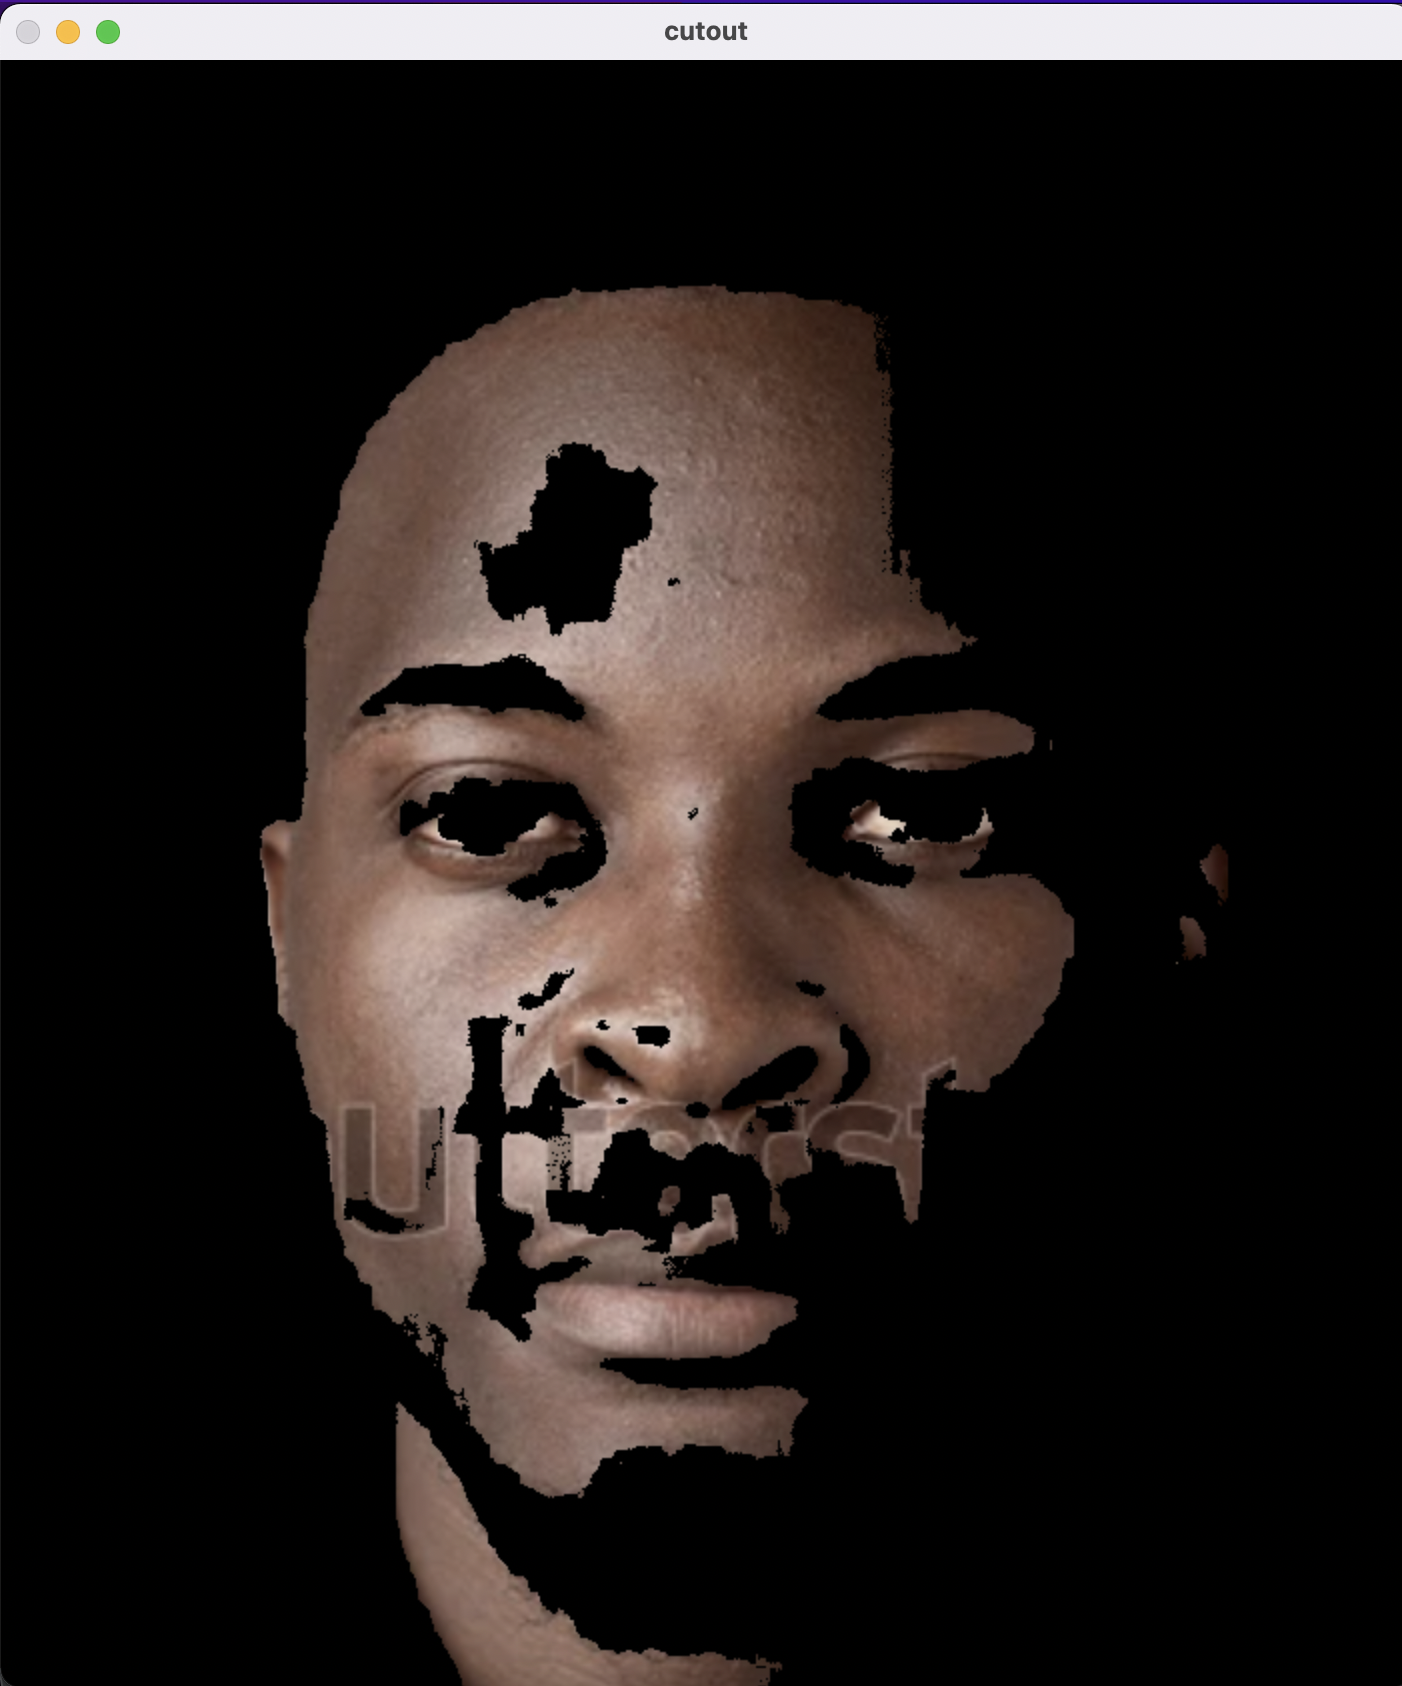

# Conclusion

That is a very interesting lab. If we want to get a better result, we need do more test to rich our model.

1. According to the patch, we could use the rgb to find the similar color, which could help us to find the skin.

2. If we hope to get a better patch, we need do more test to rich our distribution.

3. When the brightness decrease, the sensitive also decrease. More light more sensitive, we could find the background better.

4. Using the new method and model could get a better result.

url of this colab: https://colab.research.google.com/drive/1uUKGBCndXIy1qBgwvtUgTqUtUw1RJjhX?usp=sharing